# **Global Wheat Detection - FasterRCNN**
***Ido Zada .Id: 203531058***

***Roman Prasolov .Id: 313091746***

Following the existing train.csv file and multiple reading of different models we realized that we had to use FasterRCNN model in order to solve the what was expected from us in this kind of competition.

We'll explain How this model works and what kind of parameters we should have.

# **Architecture of FasterRCNN**
The architecture of Faster R-CNN is complex because it has several moving parts.

It all starts with an image, from which we want to obtain:


1.   a list of bounding boxes.
2.   a label assigned to each bounding box.
3.   a probability for each label and bounding box.


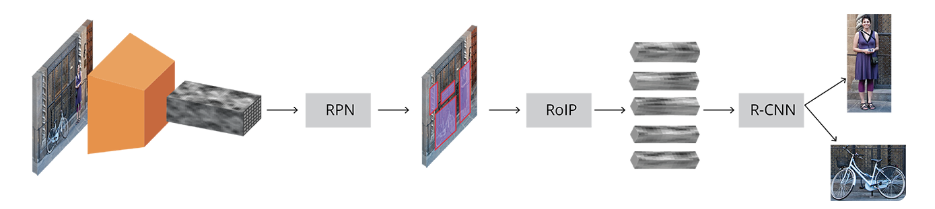

**Base network**



The first step is using a CNN pretrained for the task of classification and using the output of an intermediate layer.

In this notebook we were using resnet50-fpn.

FPN composes of a bottom-up and a top-down pathway. The bottom-up pathway is the usual convolutional network for feature extraction.

ResNet architectures have mostly replaced VGG as a base network for extracting features.

The obvious advantage of ResNet over VGG is that it is bigger, hence it has more capacity to actually learn what is needed. 

This is true for the classification task and should be equally true in the case of object detection.

**Anchors**

Our objective is to find bounding boxes in the image. These have rectangular shape and can come in different sizes and aspect ratios. Imagine we were trying to solve the problem knowing beforehand that there are two objects on the image. The first idea that comes to mind is to train a network that returns 8 values: two `[xmin, ymin, xmax, ymax]`
tuples defining a bounding box for each object. This approach has some fundamental problems.

It turns out that there is a simpler approach to predicting bounding boxes by learning to predict offsets from reference boxes. 

We take a reference box x_center, y_center, width, height and learn to predict 

Δ
​x
​center
​​ 
​​, Δ 
​y
​center 
​​, Δ 
​width
​​, Δ
​height, which are usually small values that tweak the reference box to better fit what we want.

**Region Proposal Network**

The RPN takes all the reference boxes (anchors) and outputs a set of good proposals for objects. It does this by having two different outputs for each of the anchors.

The RPN is implemented efficiently in a fully convolutional way, using the convolutional feature map returned by the base network as an input.

For the classification layer, we output two predictions per anchor: the score of it being background (not an object) and the score of it being foreground (an actual object).

For the regression, or bounding box adjustment layer, we output 4 predictions: the deltas 

Δ
​x
​center
​​ 
​​, Δ
​y
​center
​​ 
​​, Δ
​width
​​, Δ
​height
​​ which we will apply to the anchors to get the final proposals.

Using the final proposal coordinates and their “objectness” score we then have a good set of proposals for objects.


**Training, target and loss functions**

The RPN does two different type of predictions: the binary classification and the bounding box regression adjustment.

For training, we take all the anchors and put them into two different categories. Those that overlap a ground-truth object with an Intersection over Union (IoU) bigger than 0.5 are considered “foreground” and those that don’t overlap any ground truth object or have less than 0.1 IoU with ground-truth objects are considered “background”.

**Region of Interest Pooling**

We have a bunch of object proposals with no class assigned to them. Our next problem to solve is how to take these bounding boxes and classify them into our desired categories.

Faster R-CNN tries to solve, or at least mitigate, this problem by reusing the existing convolutional feature map. This is done by extracting fixed-sized feature maps for each proposal using region of interest pooling. Fixed size feature maps are needed for the R-CNN in order to classify them into a fixed number of classes.

**Region-based Convolutional Neural Network**

Region-based convolutional neural network (R-CNN) is the final step in Faster R-CNN’s pipeline. After getting a convolutional feature map from the image, using it to get object proposals with the RPN and finally extracting features for each of those proposals (via RoI Pooling), we finally need to use these features for classification. R-CNN tries to mimic the final stages of classification CNNs where a fully-connected layer is used to output a score for each possible object class.

R-CNN has two different goals:

1.   Classify proposals into one of the classes, plus a background class (for removing bad proposals). 

2.   Better adjust the bounding box for the proposal according to the predicted class.


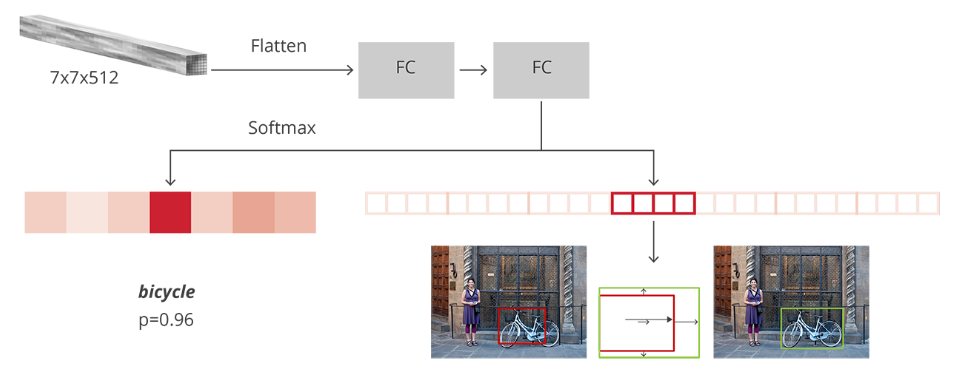

**Training and targets**

Targets for R-CNN are calculated in almost the same way as the RPN targets, but taking into account the different possible classes. We take the proposals and the ground-truth boxes, and calculate the IoU between them.

Those proposals that have a IoU greater than threshold (most of the time we will choose the defualt parameter 0.5) with any ground truth box get assigned to that ground truth. Those values are hyperparameters that can be tuned to better fit the type of objects that you are trying to find.

The targets for the bounding box regression are calculated as the offset between the proposal and its corresponding ground-truth box, only for those proposals that have been assigned a class based on the IoU threshold.

After training the model we end up with four different losses.
They are combined using a weighted sum. This is because we may want to give classification losses more weight relative to regression ones, or maybe give R-CNN losses more power over the RPN's.

**Evaluation**

The evaluation is done using the standard Mean Average Precision (mAP) at some specific IoU threshold. mAP is a metric that comes from information retrieval, and is commonly used for calculating the error in ranking problems and for evaluating object detection problems.

The important takeway is that mAP penalizes you when you miss a box that you should have detected, as well as when you detect something that does not exist or detect the same thing multiple times.

In [2]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ghv40b68
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ghv40b68
     |████████████████████████████████| 952kB 5.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65438 sha256=ee07341630c3e05f3c843cdc6308609f354c7874e37d80faf559cff41d1a2b1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-uw8vp_pg/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
!pip install ensemble-boxes

In [5]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim
import os
import glob
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
import random
import time
from datetime import datetime
from ensemble_boxes import *
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (Blur, MotionBlur, MedianBlur, GaussianBlur,
                            VerticalFlip, HorizontalFlip, IAASharpen,
                            OneOf, Compose , BboxParams, Resize ,RandomSizedCrop,
                            ToGray , Cutout , HueSaturationValue , RandomBrightnessContrast)

# **Path directories**

In [6]:
DIR_PATH = '/content/drive/My Drive/Global Wheat Detection/'
dir = glob.glob(os.path.join('/content/drive/My Drive/Global Wheat Detection/*'))
dir.sort(reverse=True)
train_paths = glob.glob(os.path.join(dir[1] , '*'))
test_paths = glob.glob(os.path.join(dir[2] , '*'))
print(dir)

['/content/drive/My Drive/Global Wheat Detection/train.csv', '/content/drive/My Drive/Global Wheat Detection/train', '/content/drive/My Drive/Global Wheat Detection/test', '/content/drive/My Drive/Global Wheat Detection/submission', '/content/drive/My Drive/Global Wheat Detection/sample_submission.csv', '/content/drive/My Drive/Global Wheat Detection/fasterrcnn_resnet50_fpn', '/content/drive/My Drive/Global Wheat Detection/efficientdet_d7', '/content/drive/My Drive/Global Wheat Detection/efficientdet_d5']


# **Read Dataframe**

In [8]:
df = pd.read_csv(dir[0])
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)

In [9]:
df.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

# **Help functions**

In [10]:
def show_image(image, boxes, title):
  fig, ax = plt.subplots(1, 1, figsize=(25, 8))
  boxes = boxes.astype(np.int32)
  for box in boxes:
      cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 3)
  ax.set_title(title) 
  ax.set_axis_off()
  ax.imshow(image);


def load_image_and_boxes(image_path):
  image_id = image_path.split('/')[-1].split('.')[0]
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  records = df[df['image_id'] == image_id]
  boxes = records[['x', 'y', 'w', 'h']].values
  boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
  boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
  return image, boxes


def images_after_augmentation(original_image, boxes, augmentation):
    aug_image = original_image.copy()
    boxes = boxes.astype(np.int32)
    if isinstance(augmentation , VerticalFlip) or isinstance(augmentation , HorizontalFlip):
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
    else:
      sample = {'image': aug_image, 'label': 'label'}
      compose = Compose([augmentation], p=1)
      aug_image = compose(**sample)['image']
      for box in boxes:
          cv2.rectangle(aug_image, (box[0], box[1]), (box[2],  box[3]), (1, 1, 0), 2)
    plt.figure(figsize=[12, 12])
    for i in range(len([original_image, aug_image])):
            image = [original_image, aug_image][i]
            plt.subplot(1, 2, i+1)
            plt.title(['Original Image', 'After Augmentaion'][i])
            plt.axis("off")
            plt.imshow(image)
    plt.show()


# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 8))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


BOX_COLOR = (255, 255, 0)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=3):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax =  int(xmin), int(ymin), int(xmax), int(ymax)
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=BOX_COLOR, thickness=thickness)
    return img

def visualizeTarget(image, target , visualize_data_loader = True):
  boxes = target['boxes']
  if visualize_data_loader:
    if not type(boxes).__module__ == np.__name__:
      boxes = boxes.numpy()
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
  img = image.copy()
  for idx, bbox in enumerate(boxes):
      img = visualize_bbox(img, bbox)
  return img

# **Examples**

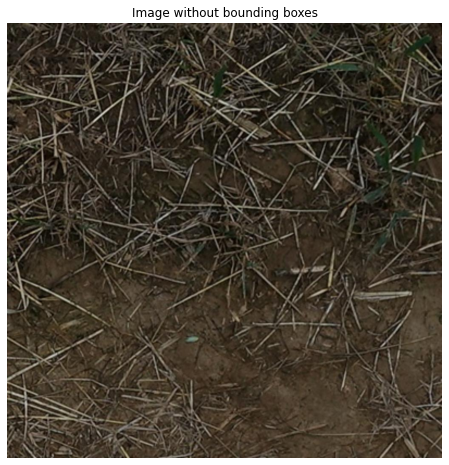

In [8]:
image_id = '8425a537b.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image without bounding boxes")

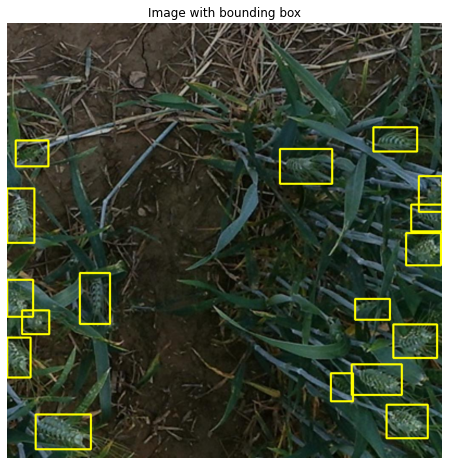

In [9]:
image_id = 'b3c96d5ad.jpg'
image_path = glob.glob(os.path.join(dir[1] , image_id))
image , boxes  = load_image_and_boxes(image_path[0])
show_image(image, boxes, "Image with bounding box")

# **Examples of some augmentations that we will use for our train** 

## **Blur**

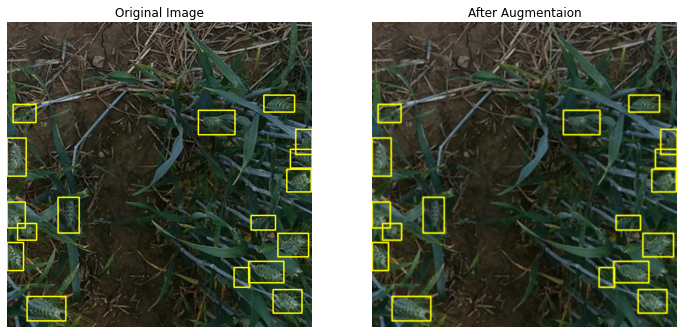

In [10]:
images_after_augmentation(image, boxes, Blur(blur_limit=7 ,p=1))

## **Vertical Flip**

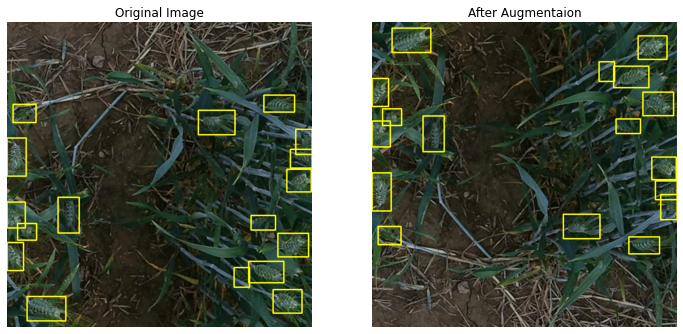

In [11]:
images_after_augmentation(image, boxes, VerticalFlip(p=1))

## **Horizontal Flip**

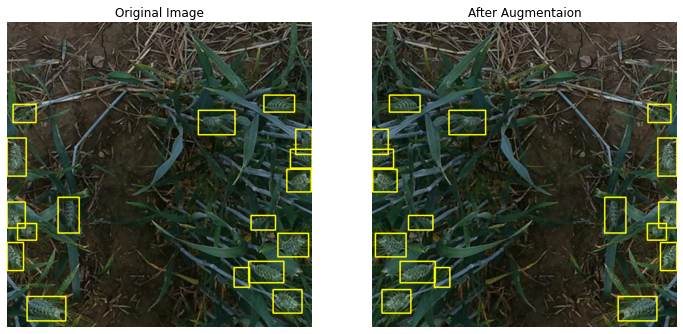

In [12]:
images_after_augmentation(image, boxes, HorizontalFlip(p=1))

# **Cutout**

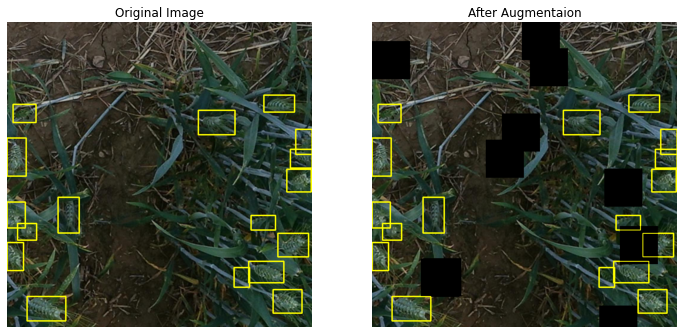

In [13]:
images_after_augmentation(image, boxes, Cutout(num_holes=10, max_h_size=128, max_w_size=128, fill_value=0, p=1.0))

# **Wheat dataset**

In [11]:
class WheatDataset(Dataset):
  def __init__(self , paths , dataframe ,  transforms = None):
    super().__init__()
    self.paths = paths
    self.dataframe = dataframe
    self.transforms = transforms

  def __getitem__(self, index):
    path_image = self.paths[index]

    image, boxes = self.load_image_and_boxes(index)
       
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
 
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([index])

    if self.transforms:
      sample = self.transforms(**{
              'image': image,
              'bboxes': target['boxes'],
              'labels': labels
          })
      image = sample["image"]
      target['bboxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
      target['bboxes'] =  target['bboxes'].reshape(-1, 4)
      target["boxes"] = target["bboxes"]
      del target['bboxes']
    else:
      target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
      target['boxes'] =  target['boxes'].reshape(-1, 4)
    image = np.transpose(image,(2,0,1))
    image = torch.from_numpy(image)
    return image, target, path_image

  def __len__(self):
      return len(self.paths)

  def load_image_and_boxes(self, index):
        path_image = self.paths[index]
        image_id = path_image.split('/')[-1].split('.')[0]
        image = cv2.imread(path_image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].to_numpy()
        area = (boxes[:, 2] * boxes[:, 3])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

**Split 80% of data to train and 20% to validation**

In [12]:
train_path , valid_path = train_test_split(train_paths,test_size=0.2)

# **Augmentations**

In [13]:
# transforms_train = Compose([IAASharpen(p = 0.5),RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),ToGray(p=0.01),
#                             Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
#                             OneOf([HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
#                                     RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.9)]),
#                             OneOf([Blur(blur_limit=3), MotionBlur(blur_limit=3), MedianBlur(blur_limit=3)]),
#                             OneOf([VerticalFlip(), HorizontalFlip()])
#                             ],p = 0.9,bbox_params=BboxParams(format='pascal_voc', min_area=0, 
#                                                min_visibility=0, label_fields=['labels']))

transforms_train = Compose([IAASharpen(p = 0.5), RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),ToGray(p=0.01),
                            Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                            OneOf([HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                                    RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.9)]),
                            OneOf([Blur(blur_limit=3), MotionBlur(blur_limit=3), MedianBlur(blur_limit=3)]),
                            OneOf([VerticalFlip(), HorizontalFlip()])
                            ],p = 0.9,bbox_params=BboxParams(format='pascal_voc', min_area=0, 
                                               min_visibility=0, label_fields=['labels']))

# **Dataloader**

In [14]:
def collate_fn(batch):
  return tuple(zip(*batch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


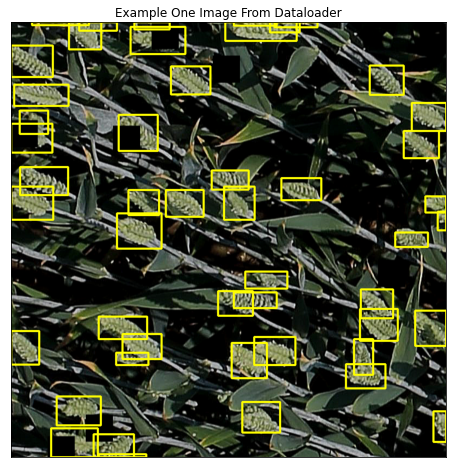

In [15]:
bs = 8
num_workers = 8
train_set = WheatDataset(train_path,df , transforms=transforms_train)
valid_set = WheatDataset(valid_path,df)

train_loader = DataLoader(train_set,batch_size = bs ,shuffle = True,collate_fn=collate_fn , num_workers=num_workers)
valid_loader = DataLoader(valid_set,batch_size = bs ,shuffle = True,collate_fn=collate_fn , num_workers=num_workers)

images , targets , path_images = next(iter(train_loader))
img = visualizeTarget(images[0],targets[0])
visualize(Example_one_image_from_dataloader = img)

# **Train/Validation**

In [16]:
class Calculator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
class Training:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.best_calc_loss = 10**5

        self.model = model
        self.device = device

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)


    def train_loop(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                print(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            calc_loss = self.train_one_epoch(train_loader)
            self.config.epoch.append(e)
            self.config.train_loss.append(calc_loss.avg)
            print(f'Train. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save_model(f'{self.base_dir}/last-epoch.bin')

            t = time.time()
            calc_loss = self.valid_one_epoch(validation_loader)
            self.config.valid_loss.append(calc_loss.avg)
            print(f'Val. Epoch: {self.epoch}, Loss: {calc_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if calc_loss.avg < self.best_calc_loss:
                self.best_calc_loss = calc_loss.avg
                self.model.eval()
                self.save_model(f'{self.base_dir}/best-model-{str(self.epoch).zfill(2)}epoch.bin')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=calc_loss.avg)

            self.epoch += 1


    def train_one_epoch(self, train_loader):
      self.model.train()
      calc_loss = Calculator()
      t = time.time()
      for images, targets, image_ids in tqdm_notebook(train_loader):
        batch_size = len(images)
        images = list(image.to(device).float() for image in images)
        target_res = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, target_res)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        self.optimizer.zero_grad()
        losses.backward()
        self.optimizer.step()
        calc_loss.update(loss_value, batch_size)

        if self.config.step_scheduler:
          self.scheduler.step()

      return calc_loss


    def valid_one_epoch(self, val_loader):
        self.model.train()
        calc_loss = Calculator()
        t = time.time()
        for images, targets, image_ids in tqdm_notebook(val_loader):
            with torch.no_grad():
                batch_size = len(images)
                images = list(image.to(device).float() for image in images)
                target_res = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images , target_res)
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()
                calc_loss.update(loss_value, batch_size)

        return calc_loss


    def save_model(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_calc_loss': self.best_calc_loss,
            'epoch': self.epoch,
        }, path)


    def load_model(self, path):
        model = torch.load(path)
        self.model.load_state_dict(model['model_state_dict'])
        self.optimizer.load_state_dict(model['optimizer_state_dict'])
        self.scheduler.load_state_dict(model['scheduler_state_dict'])
        self.best_calc_loss = model['best_calc_loss']
        self.epoch = model['epoch'] + 1


    def display_graph(self):
      plt.plot(self.config.epoch, self.config.train_loss)
      plt.plot(self.config.epoch , self.config.valid_loss)
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend(["Train", "Validation"])

# **FasterRCNN Model**
`num_classes = 2` - class 1 for Wheat and 0 for background  





In [18]:
def get_model(num_classes = 2):
  fpn_resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = fpn_resnet.roi_heads.box_predictor.cls_score.in_features
  fpn_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  fpn_resnet._name_ = "fpn_resnet"
  return fpn_resnet

In [19]:
class GlobalParametersTrain:
    lr = 0.0002
    n_epochs = 40 

    train_loss = []
    valid_loss = []
    epoch = []
    
    folder = '/content/drive/My Drive/Global Wheat Detection/fasterrcnn_resnet50_fpn'

    verbose = True
    verbose_step = 10

    step_scheduler = False 
    validation_scheduler = True 
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(mode='min',factor=0.5,patience=1,verbose=False, threshold=0.0001,threshold_mode='abs',cooldown=0, min_lr=1e-8,eps=1e-08)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training = Training(model=get_model().to(device), device=device, config=GlobalParametersTrain)
training.train_loop(train_loader, valid_loader)
training.display_graph()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth




2020-08-06T15:59:45.488838
LR: 0.0002


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training = Training(model=get_model(2).to(device), device=device, config=GlobalParametersTrain)

training.load_model('/content/drive/My Drive/Global Wheat Detection/fasterrcnn_resnet50_fpn/best-model-27epoch.bin')
model = training.model
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [45]:
def make_predictions(images ,  score_threshold=0.22):
    images = list(img.to(device) for img in images)
    predictions = []
    with torch.no_grad():
        outputs = model(images)
        for i in range(len(images)):
            boxes = outputs[i]['boxes'].data.detach().cpu().numpy()    
            scores = outputs[i]['scores'].data.detach().cpu().numpy()
            labels = outputs[i]['labels'].detach().cpu().numpy()
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return predictions

### **Example ground truth boxes and predict boxes**

In [46]:
valid_set = WheatDataset(valid_path,df)
valid_loader = DataLoader(valid_set,batch_size = 4 ,shuffle = True,collate_fn=collate_fn , num_workers=num_workers)


for j, (images, targets , image_ids) in enumerate(valid_loader):
    break
predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

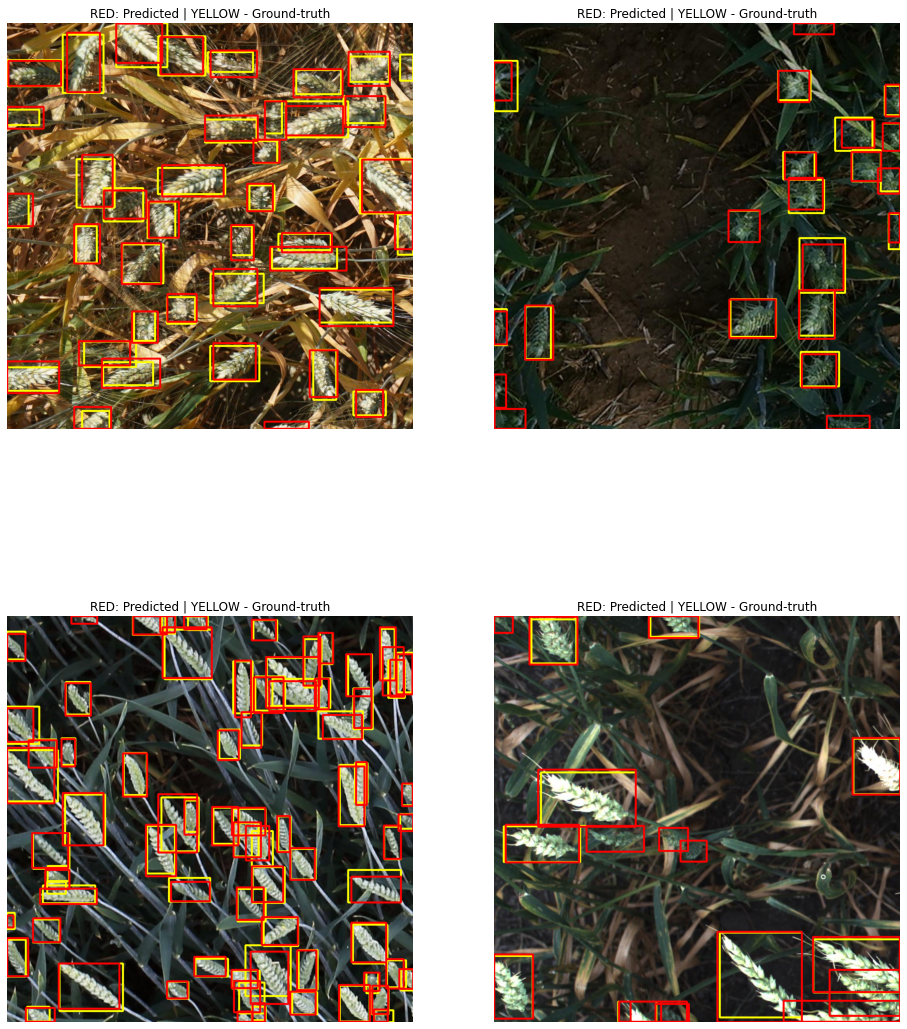

In [47]:
def draw_gt_pred_images(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{dir[1]}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    preds = preds.astype(np.int32)
    gt_boxes = gt_boxes.astype(np.int32)

    #Draw ground truth boxes
    for gt_box in gt_boxes:    
        cv2.rectangle(sample,(gt_box[0], gt_box[1]),(gt_box[2], gt_box[3]),(255, 255, 0), 3)
    
    #Draw predict boxes
    for pred_box in preds:
        cv2.rectangle(sample,(int(pred_box[0]), int(pred_box[1])),(int(pred_box[2]), int(pred_box[3])),(255, 0, 0), 3)
    
    return sample


fig = plt.figure(figsize = [16,20])
for i in range(4):
  image_id = image_ids[i].split('/')[-1][:-4]
  sample = draw_gt_pred_images(image_id, predictions[i]['boxes'], targets[i]['boxes'].numpy())
  fig.add_subplot(2,2,i+1)
  plt.title(f'RED: Predicted | YELLOW - Ground-truth')
  plt.axis("off")
  plt.imshow(sample)
plt.show()

# **Weighted Boxes Fusion**
**Why WBF can be better than NMS or SoftNMS?**

Both NMS and Soft-NMS exclude some boxes, but WBF
uses information from all boxes. It can fix some cases where
all boxes are predicted inaccurate by all models. NMS will
leave only one inaccurate box, while WBF will fix it using
information from all 3 boxes. 

See the example in Fig. 1 ,
red predictions, blue ground truth.

*Reference* : https://arxiv.org/pdf/1910.13302.pdf


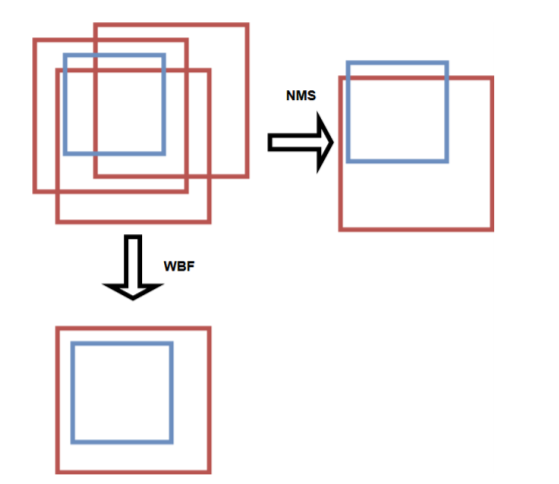

In [48]:
def run_wbf(predictions,weights=None,image_size=1024,iou_thr=0.5,skip_box_thr=0.43):
    boxes_list = [(pred["boxes"] / (image_size-1)).tolist() for pred in predictions]
    scores_list = [pred["scores"].tolist() for pred in predictions]
    labels_list = [np.ones(len(score)).astype(int).tolist() for score in scores_list]
    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

    return boxes, scores, labels

# **Load Best Model**

In [49]:
training = Training(model=get_model(2).to(device), device=device, config=GlobalParametersTrain)
training.load_model('/content/drive/My Drive/Global Wheat Detection/fasterrcnn_resnet50_fpn/Notebook_2_Score_0.7112/best-model-0027epoch.bin')
model = training.model

# **Test Time Augmentation**

WBF method could be rephrased as a merging process of multiple predictions. These multiple predictions can come from different models or a single model using TTA.
Indeed, the whole of TTA (Test-Time Augmentation) is to make our single model make multiple predictions for a single having that have been augmented. All these predictions are then merged using WBF even if they come from a single model.

This is how it would be used:

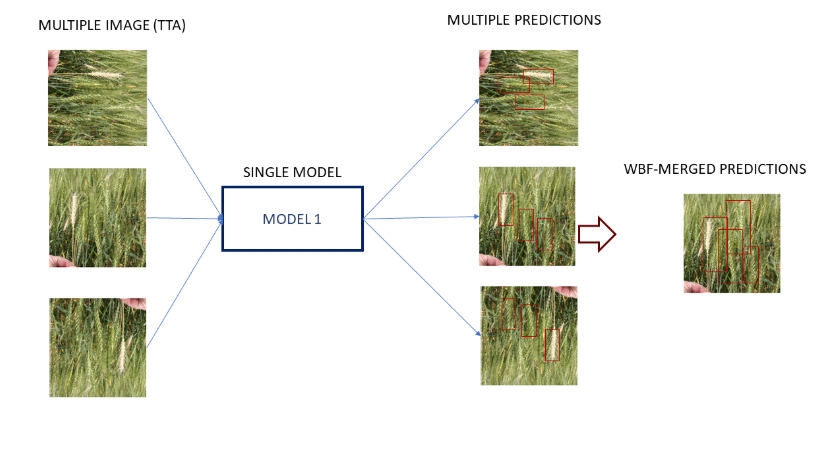

### **TTA Class**

In [50]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [51]:
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], [TTAVerticalFlip(), None],[TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [52]:
def display_tta(path):
    iou_thr = 0.4
    detection_threshold = 0.5
    model.cuda()
    model.eval()

    img = plt.imread(path).astype(np.float32)
    img /= 255.0
    
    t = Compose([Resize(width=512,height=512),ToTensorV2()])
    data = { "image": img}
    data = t(**data)
    
    img_tensor = data["image"]
    img_tensor = img_tensor.squeeze(0)
    selected_tta = random.choice(tta_transforms)
    
    tta_image = selected_tta.augment(img_tensor)
    outputs = model(tta_image.unsqueeze(0).cuda())
    boxes = outputs[0]['boxes'].data.detach().cpu().numpy()
    scores = outputs[0]['scores'].data.detach().cpu().numpy() 
    
    boxes = boxes[scores >= detection_threshold]
    scores = scores[scores >= detection_threshold]
    original_boxes  = selected_tta.deaugment_boxes(boxes.copy())
    
    img_tta = tta_image.permute(1,2,0).detach().cpu().numpy()
    img = img_tensor.permute(1,2,0).detach().cpu().numpy()

    return img , img_tta , boxes , original_boxes

# **Examples with TTA  - Test time augmentation**

In [56]:
for image_path in test_paths:
    img , tta_img , boxes , original_boxes = display_tta(image_path)
    original_with_boxes = visualizeTarget(img,{"boxes": original_boxes},visualize_data_loader = False)
    tta_with_boxes = visualizeTarget(tta_img,{"boxes": boxes},visualize_data_loader = False)
    visualize(input_image = img, image_with_tta_bounding_boxes = tta_with_boxes , original_with_bounding_boxes = original_with_boxes)

Output hidden; open in https://colab.research.google.com to view.

In [57]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for row in zip(scores, boxes):
        score , x_min , y_min , x_max,y_max =row[0], row[1][0], row[1][1], row[1][2], row[1][3]
        x = round(x_min)
        y = round(y_min)
        h = round(x_max-x_min)
        w = round(y_max-y_min)
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(score, x , y , h , w))
    return " ".join(pred_strings)

In [58]:
model.cuda()
model.eval()

iou_thr = 0.4
detection_threshold = 0.5
n = 20

submission = []

for image_path in tqdm(test_paths):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) 
    image /= 255.0
    t = Compose([Resize(width=512,height=512),ToTensorV2()])
    data = { "image": image}
    data = t(**data)
    image = data["image"]
    image = image.squeeze(0)
   
    predictions = []
    
    for i in range(n):
        selected_tta = random.choice(tta_transforms)
        tta_image = selected_tta.augment(image)
        outputs = model(tta_image.unsqueeze(0).cuda())
        boxes = outputs[0]['boxes'].data.detach().cpu().numpy()
        scores = outputs[0]['scores'].data.detach().cpu().numpy()
        boxes = boxes[scores >= detection_threshold]
        scores = scores[scores >= detection_threshold]
        original_boxes  = selected_tta.deaugment_boxes(boxes)
        predictions.append({"boxes"  : original_boxes,'scores': scores})
    
    boxes, scores, labels = run_wbf(predictions,iou_thr=iou_thr,image_size=512)
    boxes = boxes * 1024.0
        
    image = image.permute(1,2,0).detach().cpu().numpy()
    image = cv2.resize(image,(1024,1024))
    original_with_boxes = visualizeTarget(image,{"boxes": boxes} , visualize_data_loader = False)
 
    visualize(image_test=original_with_boxes)

    prediction_string = format_prediction_string(boxes, scores)
    
    image_name = image_path.split("/")[-1].split(".")[0]
    submission.append([image_name, prediction_string])

Output hidden; open in https://colab.research.google.com to view.

# **Submission**

In [55]:
SUBMISSION_PATH = '/content/drive/My Drive/Global Wheat Detection/submission'
submission_id = 'submission'
submission_path = os.path.join(SUBMISSION_PATH, '{}.csv'.format(submission_id))
sample_submission = pd.DataFrame(submission, columns=["image_id","PredictionString"])
sample_submission.to_csv(submission_path, index=False)
submission_df = pd.read_csv(submission_path)
submission_df

image_id                                   PredictionString
0  51b3e36ab  0.9990 839.0 446.0 185.0 152.0 0.9989 545.0 28...
1  348a992bb  0.9981 736.0 225.0 139.0 85.0 0.9969 599.0 446...
2  2fd875eaa  0.9992 466.0 352.0 125.0 98.0 0.9988 107.0 586...
3  51f1be19e  0.9971 611.0 87.0 153.0 177.0 0.9962 500.0 466...
4  aac893a91  0.9985 556.0 531.0 128.0 193.0 0.9950 697.0 38...
5  cc3532ff6  0.9993 774.0 832.0 164.0 160.0 0.9979 377.0 0....
6  cb8d261a3  0.9971 19.0 558.0 187.0 111.0 0.9966 756.0 489...
7  796707dd7  0.9966 709.0 823.0 113.0 105.0 0.9965 943.0 69...
8  f5a1f0358  0.9983 943.0 431.0 81.0 189.0 0.9974 136.0 751...
9  53f253011  0.9981 931.0 202.0 93.0 138.0 0.9979 468.0 467...

# **Summary**

In this notebook we started with FasterRCNN model. 

As mentioned at the beginning of the notebook the data obtained from the train.csv file as well as the goals set in the competition led us to choose this model.


**Notebook steps:**

1.   Read train.csv file
2.   Augmentations

1.   Define Dataloader
2.   Train / Validation

1.   Load model
2.   Weighted Boxes Fusion 

1.   Test Time Augmentation

1.   Calculate score and prediction (Test)
2.   Create submission csv file



The first time we ran the notebook without augmentations we got a relatively low prediction so we decided to add augmentations to improve the training and even make the model better predict during validation (Validation loss decreased), which resulted in a significant improvement in bboxes prediction.

As a result, we decided to spend quite a bit of time choosing which augmentations are relevant to this type of training.

The model predicted a number of bboxes on wheat and following articles we read on the subject we came to the conclusion that using NMS will not help, this may eliminate "good"
boxes when objects are highly
overlapping… no good solution so we decided to use a method called WBF which can be seen extensively in the notebook.

We saw quite a few notebooks and recommendations to use TTA and realized that we should do that, because we have singel model on which we run the test set.
This approach is intended for situations where the amount of data in the test is relatively small for the training performed and in addition in a situation where there is a single model (Another explanation is described in this notebook).

Finally, the model receives a set of images and output for each them.

Outputs:

Boxes -  when the boxes indicate the coordinates in the format x, y, w, h.

Score - probability value between 0 and 1.

Label - to which category the box belongs.

In this notebook of **FasterRCNN** model we got the best score of **0.7112**

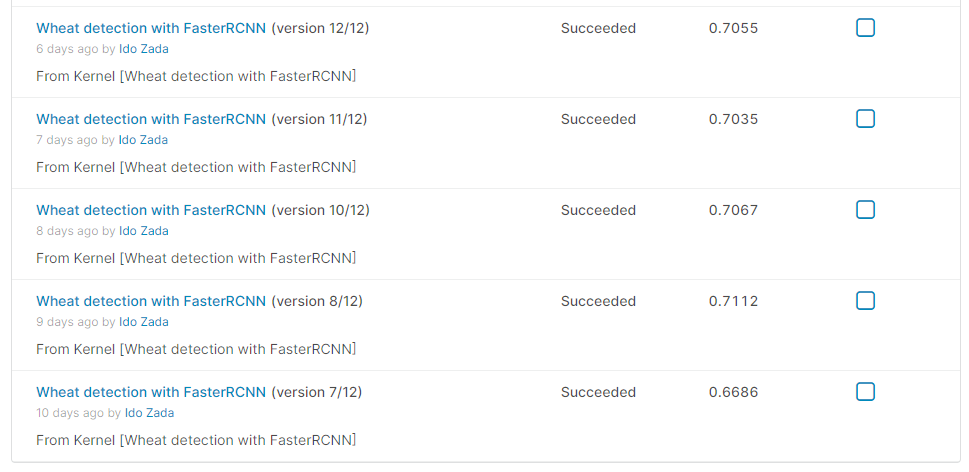

In this project we have been exposed to many methods and techniques for solving an object detection problem that we did not know.
Despite sleepless days and nights we learned a lot. The challenge in this competition caused us to improve the result and even proved to us that the theoretical part of the course will not only remain in theory but will be applied.
From day to day the motivation went up and unfortunately we reached the last day of the competition but this will probably not be the last competition we participate in.

Thank you for all the knowledge and time you have given us and hope to meet in the follow-up course.